# Image Caption Generation 
## By Siri Chakkala

## A CNN-LSTM based approach for automated image caption generation

### 1. Importing necessary libraries

In [1]:
import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import numpy as np
from tqdm.notebook import tqdm
from keras.applications import Xception
from keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout

C:\Users\Dell\OneDrive\Documents\ANACONDA\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### 2. Importing the data

In [2]:
import os

# The path to the Downloads folder
downloads_folder = os.path.expanduser('~/Downloads')

# Name of image directory within the Downloads folder
image_folder_name = 'flickr8k'

# Constructing the full path to the image directory
image_directory = os.path.join(downloads_folder, image_folder_name)

# Print the full path to the image directory
print("Path to image directory:", image_directory)

Path to image directory: C:\Users\Dell/Downloads\flickr8k


### 3. Using Xception pretrained CNN model 

In [3]:
base_model = Xception(weights='imagenet')
image_model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)
print(image_model.summary())



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]'

### 4. Preprocessing the Images / extracting the features 

In [4]:
import os
from tqdm import tqdm
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.xception import Xception, preprocess_input

# Load the pre-trained Xception model
image_model = Xception(weights='imagenet', include_top=False, pooling='avg')

featuresx = {}

# Specify the directory containing the images
directory = 'C:\\Users\\Dell\\Downloads\\flickr8k\\Images'

# Iterate through each image in the directory
for img_name in tqdm(os.listdir(directory)):
    # Load the image from file
    img_path = os.path.join(directory, img_name)
    image = load_img(img_path, target_size=(299, 299))  # Xception requires (299, 299) input shape

    # Convert image pixels to numpy array
    image = img_to_array(image)
    
    # Reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # Preprocess image for Xception
    image = preprocess_input(image)

    # Extract features using the pre-trained model (Xception)
    feature = image_model.predict(image, verbose=0)

    # Get image ID from the filename
    image_id = img_name.split('.')[0]

    # Store extracted features in the dictionary
    featuresx[image_id] = feature


100%|██████████████████████████████████████████████████████████████████████████████| 8091/8091 [43:45<00:00,  3.08it/s]


In [5]:
# features
print(len(featuresx.get("1015584366_dfcec3c85a")[0]))

2048


### 5. Storing the extracted features into pickle file

In [6]:
import os
import pickle

# Store features in pickle
pickle.dump(featuresx, open('features_x.pkl', 'wb'))

# Load features from pickle
with open('features_x.pkl', 'rb') as f:
    featuresx = pickle.load(f)

### 6. Loading the Captions data

In [7]:
captions_directory = "C:\\Users\\Dell\\Downloads\\flickr8k"
with open(os.path.join(captions_directory, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

### 7. Mapping Image IDs to Captions

In [8]:
# Create an empty dictionary to store the mapping of image IDs to captions
mapping = {}

# Iterate through each line in the 'captions_doc'
for line in tqdm(captions_doc.split('\n')):
    # Split the line by comma(,)
    tokens = line.split(',')
    
    # Check if the line has enough elements (at least 2)
    if len(line) < 2:
        continue
    # Extract the image ID and caption from the tokens    
    image_id, caption = tokens[0], tokens[1:]
    
    # Remove extension from image ID
    image_id = image_id.split('.')[0]
    
# Convert the caption list to a string by joining its elements
    caption = " ".join(caption)
    
    # Create a list if the image ID is not already in the mapping dictionary
    if image_id not in mapping:
        mapping[image_id] = []
    
    # Store the caption in the list associated with the image ID
    mapping[image_id].append(caption)
    

100%|████████████████████████████████████████████████████████████████████████| 40456/40456 [00:00<00:00, 521511.64it/s]


In [9]:
len(mapping)

8091

In [10]:
mapping["1048710776_bb5b0a5c7c"]

['a couple of several people sitting on a ledge overlooking the beach',
 'A group of people sit on a wall at the beach .',
 'A group of teens sit on a wall by a beach .',
 'Crowd of people at the beach .',
 'Several young people sitting on a rail above a crowded beach .']

### 8. Cleaning the Captions 

In [11]:
def clean(mapping):
    # Iterate through each key-value pair in the 'mapping' dictionary
    for key, captions in mapping.items():
        # Iterate through each caption associated with the current key
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]
        
            # Preprocessing steps for the caption:
            # Convert the caption to lowercase
            caption = caption.lower()
            # Delete digits, special characters, etc.
            caption = caption.replace('[^A-Za-z]', '')
            # Delete additional spaces
            caption = caption.replace('\s+', ' ')
            
            # Add start and end tags to the caption only if they are not already present
            if not caption.startswith('startseq'):
                caption = 'startseq ' + caption
            if not caption.endswith('endseq'):
                caption += ' endseq'
                
            # Remove multiple occurrences of startseq and endseq
            caption = ' '.join(caption.split())  # Remove extra spaces
            
            captions[i] = caption
            
    return mapping


In [12]:
clean(mapping)
mapping["1048710776_bb5b0a5c7c"]

['startseq a couple of several people sitting on a ledge overlooking the beach endseq',
 'startseq a group of people sit on a wall at the beach . endseq',
 'startseq a group of teens sit on a wall by a beach . endseq',
 'startseq crowd of people at the beach . endseq',
 'startseq several young people sitting on a rail above a crowded beach . endseq']

In [13]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [14]:
print(len(all_captions))
print()
print(all_captions[:10])


40455

['startseq a child in a pink dress is climbing up a set of stairs in an entry way . endseq', 'startseq a girl going into a wooden building . endseq', 'startseq a little girl climbing into a wooden playhouse . endseq', 'startseq a little girl climbing the stairs to her playhouse . endseq', 'startseq a little girl in a pink dress going into a wooden cabin . endseq', 'startseq a black dog and a spotted dog are fighting endseq', 'startseq a black dog and a tri-colored dog playing with each other on the road . endseq', 'startseq a black dog and a white dog with brown spots are staring at each other in the street . endseq', 'startseq two dogs of different breeds looking at each other on the road . endseq', 'startseq two dogs on pavement moving toward each other . endseq']


### 9. Tokenization 

In [15]:
#Create a tokenizer object to handle text tokenization
tokenizer = Tokenizer()

# Fit the tokenizer on the provided text data (all_captions)
# This process:
#   - Analyzes the text to identify unique words (vocabulary)
#   - Assigns a unique integer ID to each word
tokenizer.fit_on_texts(all_captions)
# The extra 1 accounts for the 0-th index, which is often reserved for padding
vocab_size = len(tokenizer.word_index) + 1

### 10. Storing the tokens in pickle file 

In [16]:
# Store features in pickle
pickle.dump(tokenizer, open('tokenizerx.pkl', 'wb'))

# Load features from pickle
with open('tokenizerx.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [17]:
vocab_size

8496

In [18]:
# Get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

39

In [19]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

### 11. Preparing the data

In [20]:
# Create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, featuresx, tokenizer, max_length, vocab_size, batch_size):
    
    # Initialize empty lists to store data
    X1, X2, y = list(), list(), list()
    
    n = 0 # Counter for tracking batch size
    
    while 1: # Infinite Loop to yield batches
        
        for key in data_keys: # Iterate through each image key
            n += 1
            
            captions = mapping[key]  # Retrieve captions associated with the image
            
            # process each caption
            for caption in captions:
               
            # Tokenize the caption into a sequence of integer IDs
                seq = tokenizer.texts_to_sequences([caption])[0]
                
                # Split the sequence into multiple X, y pairs for training
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # One-Hot Encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(featuresx[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                    
            # If a batch is complete, yield it and reset        
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y) # Convert to NumPy arrays
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()  # Reset lists for the next batch
                n = 0  # Reset counter

### 12. Model Building 

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, add
from tensorflow.keras.activations import relu, softmax

# Encoder Layers: 

# Image feature layers:
inputs1 = Input(shape=(2048,))  
fe1 = Dropout(0.2)(inputs1)  
fe2 = Dense(1024, activation=relu)(fe1) 
fe3 = Dense(512, activation=relu)(fe2)
fe4 = Dense(256, activation=relu)(fe3)
fe5 = Dense(128, activation=relu)(fe4)

# Sequence feature layers:
inputs2 = Input(shape=(max_length,))  
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2) 
se2 = Dropout(0.2)(se1)
se3 = LSTM(128)(se2)  

# Decoder layers:-
decoder1 = add([fe5, se3])  # Combine image and sequence features
decoder2 = Dense(128, activation=relu)(decoder1)
outputs = Dense(vocab_size, activation=softmax)(decoder2)  # Output layer with softmax for word probabilities

model = Model(inputs=[inputs1, inputs2], outputs=outputs)  # Define model with two inputs and one output
model.compile(loss='categorical_crossentropy', optimizer='adam')

### 13. Training the model

In [22]:
# train the model
epochs = 30
batch_size = 32
steps = len(train) // batch_size

for epoch in range(1, epochs+1):
    # create data generator
    generator = data_generator(train, mapping, featuresx, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1) 
    # Print epoch information
print(f'Epoch {epoch}/{epochs}')


227/227 [==============================] - 1438s 6s/step - loss: 1.8688
Epoch 30/30


In [23]:
# Save the model in the current working directory
model.save('xceptionICG_model.h5')

C:\Users\Dell\OneDrive\Documents\ANACONDA\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
def idx_to_word(integer, tokenizer):
    """
    Converts a numerical token ID back to its corresponding word using a tokenizer.

    Args:
        integer: The integer ID representing the word.
        tokenizer: The tokenizer object that was used to tokenize the text.

    Returns:
        The word corresponding to the integer ID, or None if the ID is not found.
    """

    # Iterate through the tokenizer's vocabulary
    for word, index in tokenizer.word_index.items():
        # If the integer ID matches the index of a word, return the word
        if index == integer:
            return word

    # If no matching word is found, return None
    return None

In [25]:
def predict_caption(model, image, tokenizer, max_length):
    """
    Generates a caption for an image using a trained image captioning model.

    Args:
        model: The trained image captioning model.
        image: The image to generate a caption for.
        tokenizer: The tokenizer used to convert text to numerical sequences.
        max_length: The maximum length of the generated caption.

    Returns:
        The generated caption as a string.
    """
    
    # add start tag for generation process
    in_text = 'startseq'
    
    # iterate over the max length of sequence
    for i in range(max_length):
        
        # Tokenize the current caption into a sequence of integers
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
       
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
       
        # Get the index of the word with the highest probability
        yhat = np.argmax(yhat)
        
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        
        # stop if word not found
        if word is None:
            break
        
        # append word as input for generating next word
        in_text += " " + word
        
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text


### 14. Model Evaluation

In [26]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, featuresx[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))

100%|████████████████████████████████████████████████████████████████████████████████| 810/810 [29:47<00:00,  2.21s/it]


BLEU-1: 0.574657
BLEU-2: 0.374266
BLEU-3: 0.240433


### 15. Generation of Captions compared with the actual captions 

In [27]:
from PIL import Image
def generate_caption(model, image_id, image_directory, mapping, featuresx, tokenizer, max_length):
    """
    Generate captions for an image using the trained image captioning model.

    Args:
        model: The trained image captioning model.
        image_id (str): The ID of the image.
        image_directory (str): The directory containing the images.
        mapping (dict): A dictionary mapping image IDs to captions.
        features (dict): A dictionary containing extracted features for images.
        tokenizer: The tokenizer used to encode text for the model.
        max_length: The maximum length of the generated caption.
    """
    # Construct the image path
    img_path = os.path.join(image_directory, "Images", f"{image_id}.jpg")
    
    # Load the image
    image = Image.open(img_path)
    
    # Get the captions for the image
    captions = mapping[image_id]
    
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    
    # Predict the caption
    y_pred = predict_caption(model, featuresx[image_id], tokenizer, max_length)
    
    print('--------------------Predicted--------------------')
    print(y_pred)
    
    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()


### 16. Results 

---------------------Actual---------------------
startseq a boy smiles underwater . endseq
startseq a red-headed boy swimming underwater . endseq
startseq a small boy swimming underwater endseq
startseq a smiling boy swims underwater in a pool . endseq
startseq the boys smiles underwater at the pool . endseq
--------------------Predicted--------------------
startseq a little boy swims underwater in a pool endseq


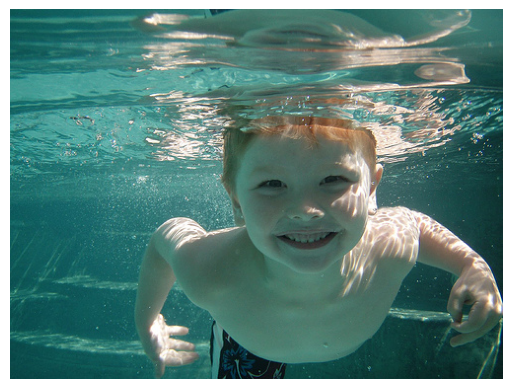

In [28]:
generate_caption(model, "1096165011_cc5eb16aa6", image_directory, mapping, featuresx, tokenizer, max_length)

---------------------Actual---------------------
startseq people on atvs and dirt bikes are traveling along a worn path in a field surrounded by trees . endseq
startseq three people are riding around on atv 's and motorcycles . endseq
startseq three people on motorbikes follow a trail through dry grass . endseq
startseq three people on two dirt-bikes and one four-wheeler are riding through brown grass . endseq
startseq three people ride off-road bikes through a field surrounded by trees . endseq
--------------------Predicted--------------------
startseq two people riding a dirt bike in a forest endseq


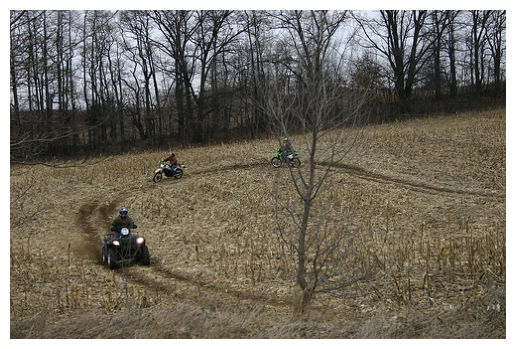

In [29]:
generate_caption(model, "112243673_fd68255217", image_directory, mapping, featuresx, tokenizer, max_length)

---------------------Actual---------------------
startseq a mother and children is fishing on a boardwalk at night . endseq
startseq a woman and three children stand on a deck with a fishing pole . endseq
startseq a woman stands with children on a boardwalk at night overlooking the sea . endseq
startseq some people on a pier at night with one girl fishing off it . endseq
startseq woman with three children fishing over boardwalk in the evening . endseq
--------------------Predicted--------------------
startseq a woman and a woman are standing on a boardwalk in front of a pier endseq


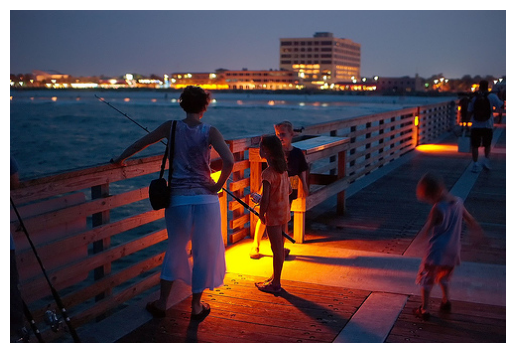

In [30]:
generate_caption(model, "1089755335_0bfbfd30e6", image_directory, mapping, featuresx, tokenizer, max_length)

---------------------Actual---------------------
startseq a man is carefully skiing down a snow covered hill wearing a backpack . endseq
startseq a person skis down a snowy hill . endseq
startseq a skier wearing a black backpack is making his way down a hill . endseq
startseq a skier with poles is walking through the snow endseq
startseq a skier carefully walks down a steep snow slope . endseq
--------------------Predicted--------------------
startseq a skier is skiing down a snow covered hill endseq


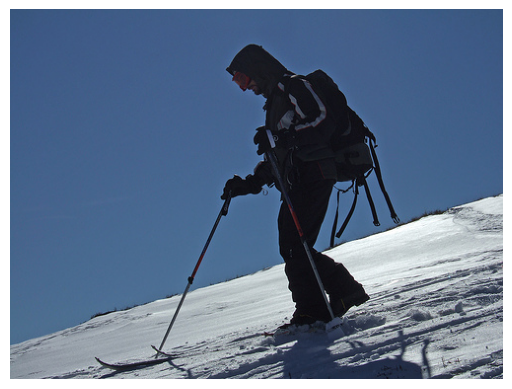

In [31]:
generate_caption(model, "1397923690_d3bf1f799e", image_directory, mapping, featuresx, tokenizer, max_length)

---------------------Actual---------------------
startseq a boy in a red and white shirt is on a swing . endseq
startseq a child looking back on a fast moving swing . endseq
startseq a litlle boy playing on a swing endseq
startseq a young boy in orange and white swings in a playground at a park . endseq
startseq a young boy plays on a swing . endseq
--------------------Predicted--------------------
startseq a girl in a pink shirt and blue jeans is swinging on a swing endseq


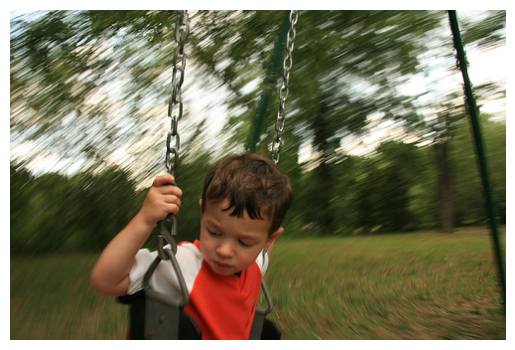

In [32]:
generate_caption(model, "1222322358_225067636e", image_directory, mapping, featuresx, tokenizer, max_length)

---------------------Actual---------------------
startseq a boy eats with a spoon . endseq
startseq a little boy holds a spoon up to his mouth . endseq
startseq a little boy is eating his food off of a spoon while sitting on a patio . endseq
startseq a small child dressed in green is eating with a spoon . endseq
startseq a young child holds a spoon to its mouth while sitting in a chair . endseq
--------------------Predicted--------------------
startseq a little boy eats fruit endseq


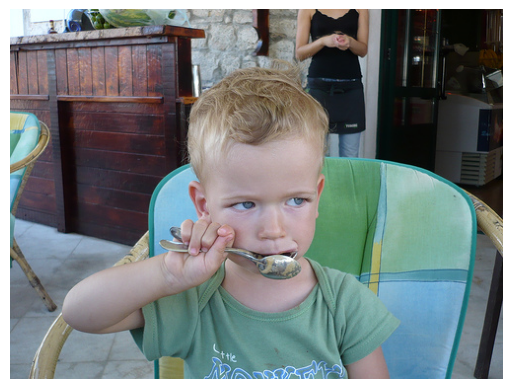

In [33]:
generate_caption(model, "1224851143_33bcdd299c", image_directory, mapping, featuresx, tokenizer, max_length)

---------------------Actual---------------------
startseq a dog in a number six jersey is running through a field . endseq
startseq a dog is leaping through the grass . endseq
startseq a dog is wearing a red number 6 and running through a field of green grass while being chased by a bird . endseq
startseq a white and tan dog leaps through the air . endseq
startseq the dog in a vest leaps in the air and there is a bird flying . endseq
--------------------Predicted--------------------
startseq a dog leaps over a hurdle endseq


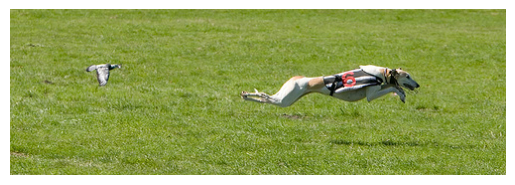

In [34]:
generate_caption(model, "1240297429_c36ae0c58f", image_directory, mapping, featuresx, tokenizer, max_length)

---------------------Actual---------------------
startseq a brown-haired child in green shoes swings on a swing in a park near the woods . endseq
startseq a child swings and the sunshine shines down on her . endseq
startseq a child wearing crocs sits on a swing in a wooded area . endseq
startseq a kid swings with his feet up in the air in a forest . endseq
startseq the sun breaks through the trees as a child rides a swing . endseq
--------------------Predicted--------------------
startseq a child swings in a park endseq


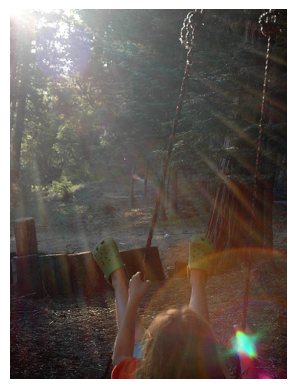

In [35]:
generate_caption(model, "1333888922_26f15c18c3", image_directory, mapping, featuresx, tokenizer, max_length)

---------------------Actual---------------------
startseq a dog in midair cathing the red ball . endseq
startseq a dog retrieves a golf ball . endseq
startseq a little brown dog stands on his hind legs with a red toy in its mouth . endseq
startseq a terrier who jumped up has a red ball in his mouth . endseq
startseq a yorkie jumped into the air to catch a red ball in its mouth . endseq
--------------------Predicted--------------------
startseq a brown dog is running through the grass with a ball in its mouth endseq


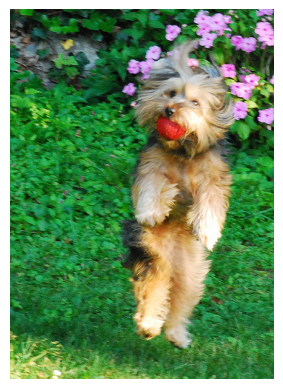

In [36]:
generate_caption(model, "1346529555_e916816cfe", image_directory, mapping, featuresx, tokenizer, max_length)

---------------------Actual---------------------
startseq two girls are walking down a dirt road in a park . endseq
startseq two women walking down a dirt road with a man far behind . endseq
startseq two women walking on an outdoor trail . endseq
startseq two young women are walking along a rural path bordered by trees . endseq
startseq two young women walk along a dirt road . endseq
--------------------Predicted--------------------
startseq a woman and a woman walk down a dirt road endseq


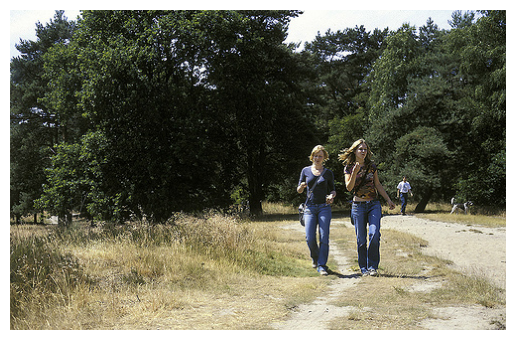

In [37]:
generate_caption(model, "134724228_30408cd77f", image_directory, mapping, featuresx, tokenizer, max_length)

---------------------Actual---------------------
startseq a child is in a harness with onlookers . endseq
startseq a girl is hooked to bungee cords as the crowd behind her watches . endseq
startseq "a girl sits in a harness ready to lift up into the air and behind her is a sign that says "" active . """ endseq
startseq little girls strapped into harnesses ready to jump up in the air . endseq
startseq "the small girl is sitting in a harness strapped to a tether while others watch ." endseq
--------------------Predicted--------------------
startseq a man swings on a red and white sports wall endseq


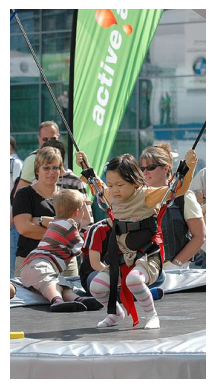

In [38]:
generate_caption(model, "1401961581_76921a75c5", image_directory, mapping, featuresx, tokenizer, max_length)

---------------------Actual---------------------
startseq a man in an orange hat pulls a cigarette out of a box . endseq
startseq a man reaches into his pack for a cigarette . endseq
startseq a man takes out a cigarette . endseq
startseq a man with a orange hat and a brown jacket has a cigarette in his mouth . endseq
startseq there is a man with a brown hat lighting a cigarette . endseq
--------------------Predicted--------------------
startseq a man wearing a black hat and sunglasses is standing next to a man wearing a black hat and a hat endseq


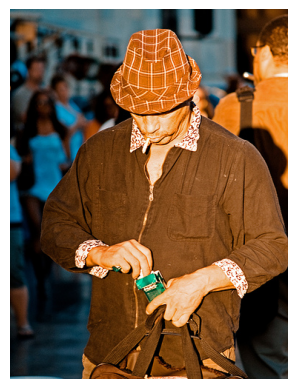

In [39]:
generate_caption(model, "1418503947_953d373632", image_directory, mapping, featuresx, tokenizer, max_length)

---------------------Actual---------------------
startseq a blonde child climbing across a net . endseq
startseq a child is playing at a park . endseq
startseq a girls climbs on a jungle gym . endseq
startseq a small child climbing on an elevated net endseq
startseq a young child climbs on a rope net . endseq
--------------------Predicted--------------------
startseq a child is climbing on a playground net endseq


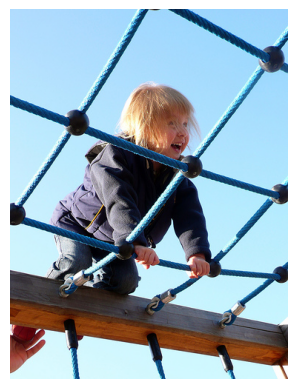

In [40]:
generate_caption(model, "1572286502_64e5c4b920", image_directory, mapping, featuresx, tokenizer, max_length)

---------------------Actual---------------------
startseq a group of people are sitting in some rows of wooden seats . endseq
startseq a group of people seated in a line of seats at an event . endseq
startseq people sit in an auditorium with programs . endseq
startseq people sitting in rows of seats . endseq
startseq students are sitting in an auditorium with notes out in front of them . endseq
--------------------Predicted--------------------
startseq a group of people sitting in a bottled beverage endseq


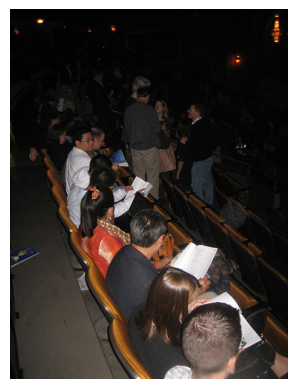

In [41]:
generate_caption(model, "1650280501_29810b46e5", image_directory, mapping, featuresx, tokenizer, max_length)

### 16. Captions generated for unseen images

1/1 [==============================] - 0s 312ms/step


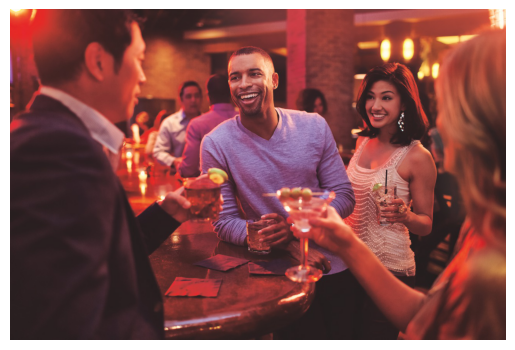

Generated Caption: startseq a woman in a white shirt and black shorts is sitting in a bar endseq


In [46]:
def generate_caption_for_custom_image(image_path):
    # Load the image
    image = load_img(image_path, target_size=(299, 299))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    # Extract features using the pre-trained InceptionV3 model
    image_features = image_model.predict(image)

    # Predict caption for the custom image
    caption = predict_caption(model, image_features, tokenizer, max_length)
    
    # Display the image and generated caption
    plt.imshow(Image.open(image_path))
    plt.axis('off')
    plt.show()
    print("Generated Caption:", caption)

# Example usage:
custom_image_path = "Bar-Scene.jpg"
generate_caption_for_custom_image(custom_image_path)


1/1 [==============================] - 0s 422ms/step


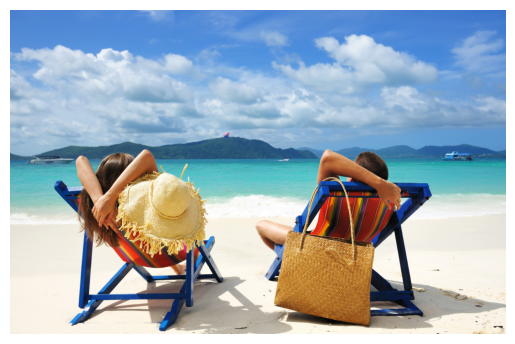

Generated Caption: startseq a woman in a red shirt and white hat is playing in the sand endseq


In [49]:
# Example usage:
custom_image_path = "348370-relaxation-couple-men-women-landscape-nature-beach-sea-relaxing-tropical-vacation.jpg"
generate_caption_for_custom_image(custom_image_path)

1/1 [==============================] - 0s 365ms/step


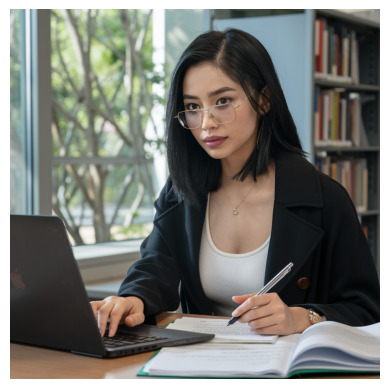

Generated Caption: startseq a woman reading reading a book while sitting on a table reading endseq


In [50]:

# Example usage:
custom_image_path = "Gen_img_1.png"
generate_caption_for_custom_image(custom_image_path)

1/1 [==============================] - 0s 391ms/step


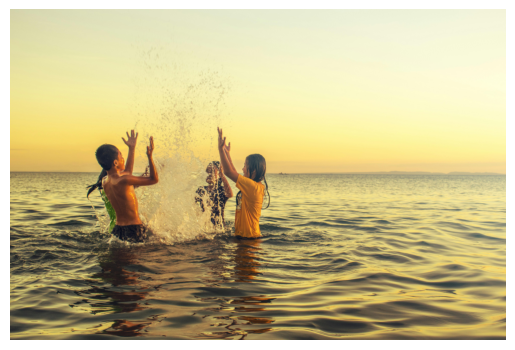

Generated Caption: startseq a man jumping into the water endseq


In [51]:
# Example usage:
custom_image_path = "group-of-people-playing-on-the-beach-707185.jpg"
generate_caption_for_custom_image(custom_image_path)

### 17. Captions for the images captured through camera 

1/1 [==============================] - 1s 910ms/step


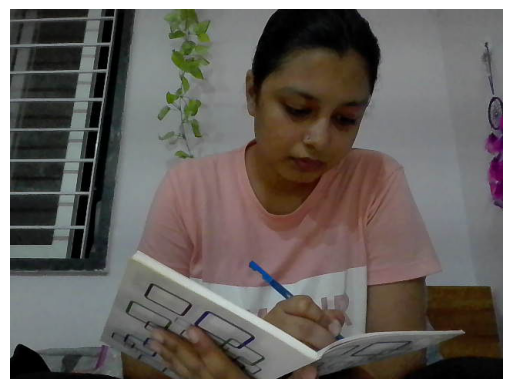

Generated Caption: startseq a man reads a book while sitting in a library endseq


In [69]:
import cv2

def capture_image_and_generate_caption():
    # Initialize the camera
    cap = cv2.VideoCapture(0)

    # Check if the camera is opened correctly
    if not cap.isOpened():
        print("Error: Could not open camera.")
        return

    # Capture a single frame from the camera
    ret, frame = cap.read()

    # Check if the frame is captured successfully
    if not ret:
        print("Error: Could not capture frame.")
        cap.release()
        return

    # Save the captured frame as an image
    image_path = "captured_image.jpg"
    cv2.imwrite(image_path, frame)

    # Close the camera
    cap.release()

    # Generate caption for the captured image
    generate_caption_for_custom_image(image_path)

# Call the function to capture image and generate caption
capture_image_and_generate_caption()
